# New Working Point Optimization Scheme

## Importing needed libraries

In [169]:
import os
import sys
from pathlib import Path
import subprocess
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from h5py import File
import itertools as it
import joblib
import time
import pandas as pd
import seaborn as sns
import scipy as sp
from IPython.display import display, HTML, Image
import uproot as up
import mplhep as hep
# Use the ATLAS style in mplhep
plt.style.use(hep.style.ATLAS)

In [170]:
import tensorflow as tf

# List available GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print(f"GPU Name: {gpu.name}, Type: {gpu.device_type}")
else:
    print("No GPUs found")

GPU Name: /physical_device:GPU:0, Type: GPU


## Accessing jets' data

In [171]:
%%time

# Getting a list of all the h5 data samples in the designated folder
folder_path = '/lustre/work/client/users/maboelela/New_TTbar_Sample/'
entries = os.listdir(folder_path)
files = [entry for entry in entries if os.path.isfile(os.path.join(folder_path, entry))]

# Loading the jets datasets from the different files into one big numpy array 
jet_arrays = []

for file in files:
    data = File(folder_path+file, 'r')
    jet_arr = data['jets']
    jet_arr = np.asarray(jet_arr)
    jet_arrays.append(jet_arr)

jets = np.concatenate(jet_arrays, axis=0)

CPU times: user 12.3 s, sys: 4.22 s, total: 16.5 s
Wall time: 17.8 s


In [172]:
# Accessing the 'Jets' Dataset
print("The attributes of each element of the dataset (jets): " + str(jets.dtype.fields.keys()))
print("The shape of the dataset is: " + str(jets.shape))

The attributes of each element of the dataset (jets): dict_keys(['pt', 'HadronConeExclTruthLabelPt', 'eta', 'TruthJetPVz', 'deltaRToTruthJet', 'deltaPtToTruthJet', 'fastDips_pb', 'fastDips_pc', 'fastDips_pu', 'fastGN120230327_pb', 'fastGN120230327_pc', 'fastGN120230327_pu', 'dipz20231122_z', 'dipz20231122_negLogSigma2', 'HadronConeExclTruthLabelID', 'HadronConeExclExtendedTruthLabelID', 'jetPtRank', 'n_super_tracks', 'mcEventWeight', 'eventNumber', 'averageInteractionsPerCrossing', 'actualInteractionsPerCrossing', 'nPrimaryVertices', 'primaryVertexBeamspotZ', 'primaryVertexDetectorZUncertainty'])
The shape of the dataset is: (32156404,)


In [173]:
print("The number of jets in the sample is: " + str(len(jets)))
print("The number of jets in the sample with pT < 20 GeV is: " + str(len(jets[jets["pt"] < 20000])))
print("The number of jets in the sample with eta > 2.5 GeV is: " + str(len(jets[jets["eta"] > 2.5])))

The number of jets in the sample is: 32156404
The number of jets in the sample with pT < 20 GeV is: 0
The number of jets in the sample with eta > 2.5 GeV is: 0


In [174]:
# Getting the events in our sample
uniques = np.unique(jets["eventNumber"])
print("The number of events in our sample is: " + str(len(uniques)))
print("The events_ID array looks like: " + str(uniques))

The number of events in our sample is: 4998623
The events_ID array looks like: [100000001 100000002 100000003 ... 121417998 121417999 121418000]


## Defining our categroized signal and backgrounds for four-jet-signature selection

In [175]:
# Retreiving our signal and background events IDs
signal_event_ids = np.array(joblib.load('./Four_Jet_Signal_Event_IDs.sav'))
background_event_ids = np.array(joblib.load('./Four_Jet_Background_Event_IDs.sav'))
#signal_event_ids = np.array(joblib.load('./Six_Jet_Signal_Event_IDs.sav'))
#background_event_ids = np.array(joblib.load('./Six_Jet_Background_Event_IDs.sav'))

## Getting the MLPL distributions for signal and background

In [163]:
# Function definitiong of the MLPL getter algorithm
def get_MLPL(event_id,jets,comb_num,num_highest_pt=555555):
    event_jets = jets[jets["eventNumber"] == event_id]
    
    if num_highest_pt != 555555:
        if len(event_jets) > num_highest_pt:
            event_jets = event_jets[(-event_jets['pt']).argsort()[:num_highest_pt]]
    
    combinations = []
    mlpl_array = []

    for combination in it.combinations(event_jets, comb_num):
        combinations.append(combination)

    for comb in combinations:
        num = 0
        denom = 0
        second_term = 0
        third_term = 0
        
        for jet in comb:
            mu = jet["dipz20231122_z"]
            sigma = np.exp(-0.5*jet["dipz20231122_negLogSigma2"])
            num += (mu) / (sigma**2)
            denom += 1 / (sigma**2)
            second_term -= np.log(sigma)
        
        for jet in comb:
            mu = jet["dipz20231122_z"]
            sigma = np.exp(-0.5*jet["dipz20231122_negLogSigma2"])
            third_term -= ((num / denom) - mu)**2 / (2*(sigma**2)) 
            
        mlpl_array.append(- (comb_num/2) * np.log(2*np.pi) + second_term + third_term)
            
    
    max_mlpl = max(mlpl_array)
        
    return max_mlpl

In [164]:
%%time
# Getting MLPL(4,All) distributions for signal and background

combination_number = 4;
#combination_number = 6;


mlpl_4_all_sig = []
mlpl_4_all_bckg = []
#mlpl_6_all_sig = []
#mlpl_6_all_bckg = []


for id in signal_event_ids[:10000]:
    mlpl_4_all_sig.append(get_MLPL(id,jets,combination_number))
    #mlpl_6_all_sig.append(get_MLPL(id,jets,combination_number))

for id in background_event_ids[:10000]:
    mlpl_4_all_bckg.append(get_MLPL(id,jets,combination_number))
    #mlpl_6_all_bckg.append(get_MLPL(id,jets,combination_number))

In [165]:
joblib.dump(mlpl_4_all_sig, 'mlpl_4_all_sig.sav')
joblib.dump(mlpl_4_all_bckg, 'mlpl_4_all_bckg.sav')
#joblib.dump(mlpl_6_all_sig, 'mlpl_6_all_sig.sav')
#joblib.dump(mlpl_6_all_bckg, 'mlpl_6_all_bckg.sav')

['mlpl_6_all_bckg.sav']

## MLPL Overlayed Histograms and ROC Curves

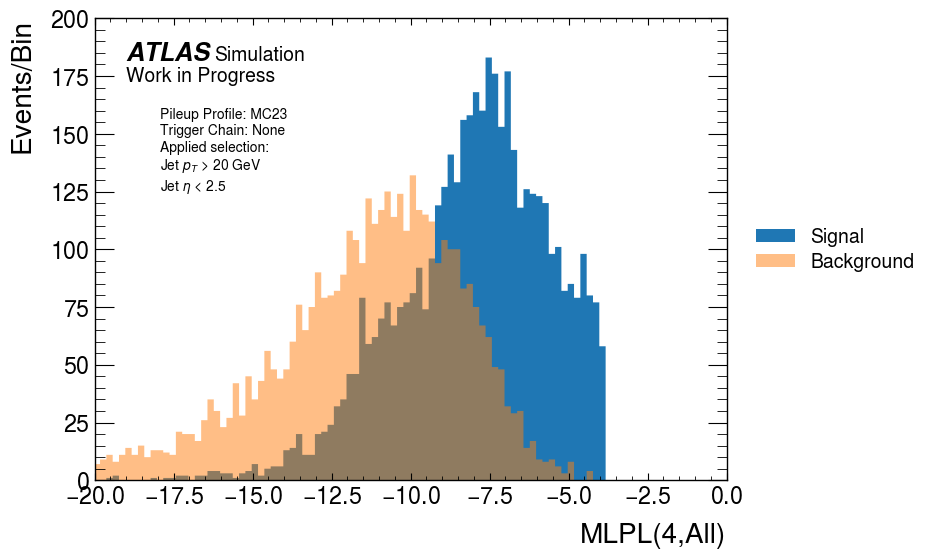

In [202]:
# MLPL Overlayed Histograms
plt.style.use(hep.style.ATLAS)
plt.figure(figsize=(8, 6))
hep.atlas.label(ax=plt.gca(), llabel="Simulation", loc=4, rlabel="Work in Progress")
bins = np.arange(min(mlpl_4_all_bckg), max(mlpl_4_all_bckg), 0.2)
plt.hist(mlpl_4_all_sig, bins, alpha=1, label='Signal', histtype='stepfilled', density=False)
plt.hist(mlpl_4_all_bckg, bins, alpha=0.5, label='Background', histtype='stepfilled', density=False)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# Adding custom text
text_x = 1e-12  # x position of the text, adjust as necessary
text_y = 0.55  # y position of the text, adjust as necessary
analysis_info = """
Pileup Profile: MC23
Trigger Chain: None
Applied selection: 
Jet $p_T$ > 20 GeV 
Jet $\eta$ < 2.5
"""
plt.text(text_x, text_y, analysis_info, transform=ax.transAxes, verticalalignment='top', fontsize=10)
#plt.title("Overlayed MLPL distributions for the MLPL(4,All) algorithm")
plt.xlabel("MLPL(4,All)")
plt.ylabel("Events/Bin")
plt.xlim([-20,0])
plt.show()

In [167]:
# ROC Curve Implementation 
bin_array = np.linspace(min(mlpl_4_all_bckg), 0, num=(0-int(min(mlpl_4_all_bckg)))*5)

signal_mlpl_4_all = np.histogram(mlpl_4_all_sig, bins=bin_array)[0]
background_mlpl_4_all = np.histogram(mlpl_4_all_bckg, bins=bin_array)[0]


sigeff_mlpl_4_all = ( signal_mlpl_4_all.sum() - signal_mlpl_4_all[:].cumsum() ) / signal_mlpl_4_all.sum()
bckgeff_mlpl_4_all = ( background_mlpl_4_all.sum() - background_mlpl_4_all[:].cumsum() ) / background_mlpl_4_all.sum()

valid = (bckgeff_mlpl_4_all > 0) & (sigeff_mlpl_4_all > 0)  
rej_mlpl_4_all = 1/bckgeff_mlpl_4_all[valid]
eff_mlpl_4_all = sigeff_mlpl_4_all[valid]

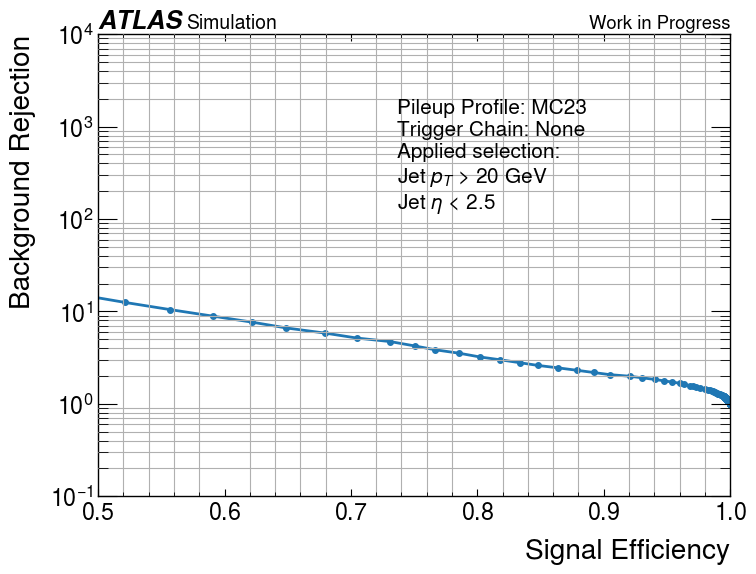

In [227]:
# ROC Curve Plotting
plt.style.use(hep.style.ATLAS)
plt.figure(figsize=(8, 6))
hep.atlas.label(ax=plt.gca(), llabel="Simulation", loc=0, rlabel="Work in Progress")
plt.plot(eff_mlpl_4_all, rej_mlpl_4_all, alpha = 1, marker = '.')
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# Adding custom text
text_x = 0.3  # x position of the text, adjust as necessary
text_y = 0.6  # y position of the text, adjust as necessary
analysis_info = """
Pileup Profile: MC23
Trigger Chain: None
Applied selection: 
Jet $p_T$ > 20 GeV 
Jet $\eta$ < 2.5
"""
plt.text(text_x, text_y, analysis_info, transform=ax.transAxes, verticalalignment='top', fontsize=15)
#plt.title("Overlayed MLPL distributions for the MLPL(4,All) algorithm")
plt.xlabel("Signal Efficiency")
plt.ylabel("Background Rejection")
plt.yscale("log")
plt.grid(which = "minor")
plt.minorticks_on()
plt.xlim([0.5,1])
#plt.ylim([0.5,1])
plt.show()

Truth jet-origin: 
 [-27.55 -27.55  34.47 -52.62 -27.55    nan    nan    nan]
Regressed DIPZ mean: 
 [-26.66 -27.03 -44.   -58.78 -26.86 -43.84 -28.25 -17.23]
Regressed DIPZ std: 
 [ 1.478  2.068 20.69  16.14   4.492  8.164 40.5   13.805]
Event MLPL(4,All) score:  -9.16870128262916


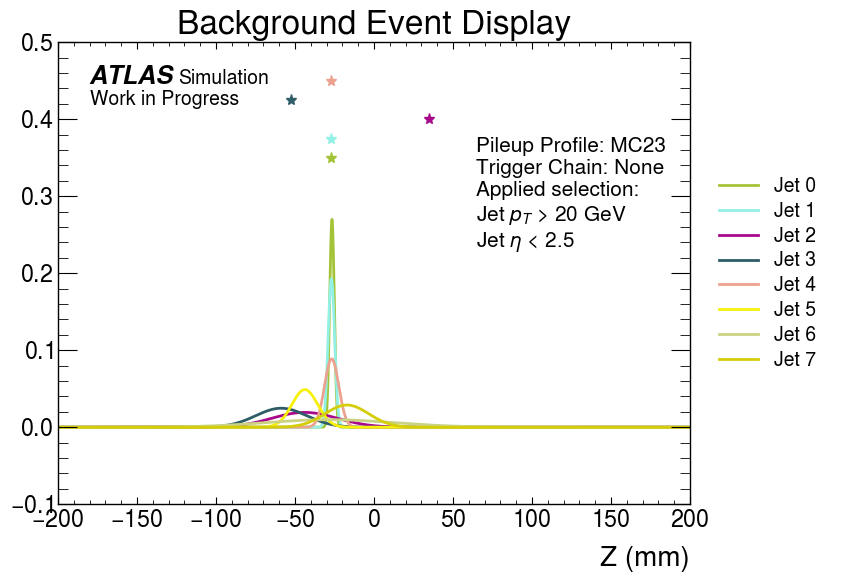

In [ ]:
from scipy.stats import norm
import random
# Sanity checks
id = background_event_ids[109]
signal_event_jets = jets[jets["eventNumber"] == id]
print("Truth jet-origin: \n" , signal_event_jets['TruthJetPVz'])
print("Regressed DIPZ mean: \n" , signal_event_jets['dipz20231122_z'])
print("Regressed DIPZ std: \n" , np.exp(-0.5*signal_event_jets['dipz20231122_negLogSigma2']))
print("Event MLPL(4,All) score: " , get_MLPL(id, jets, 4))

#z-axis ranges from -2 and 2 with .001 steps
x = np.arange(-200, 200, 0.001)

n = np.arange(0,len(signal_event_jets),1)

#Generating random colors for the plot
color=["#"+''.join([random.choice('0123456789ABCDEF') for i in range(6)])
       for j in range(len(signal_event_jets))]
ic = 0      #color counter
y = 0.35
plt.style.use(hep.style.ATLAS)
plt.figure(figsize=(8, 6))
hep.atlas.label(ax=plt.gca(), llabel="Simulation", loc=4, rlabel="Work in Progress")
for jet in signal_event_jets:
    plt.plot(x, norm.pdf(x, jet['dipz20231122_z'], np.exp(-0.5*jet['dipz20231122_negLogSigma2'])), color=color[ic], linewidth=2, label='Jet '+str(ic))
    plt.plot(jet['TruthJetPVz'], y , marker='*', color=color[ic])
    ic = ic + 1
    y += 0.025
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# Adding custom text
text_x = 0.4 # x position of the text, adjust as necessary
text_y = 0.55  # y position of the text, adjust as necessary
analysis_info =""""
Pileup Profile: MC23
Trigger Chain: None
Applied selection: 
Jet $p_T$ > 20 GeV 
Jet $\eta$ < 2.5
"""
plt.text(text_x, text_y, analysis_info, transform=ax.transAxes, verticalalignment='top', fontsize=15)
plt.title("Background Event Display")
plt.xlabel("Z (mm)")
plt.ylabel("")
#plt.xlim([-20,0])
#plt.ylim([0,0.2])
plt.show()
